In [4]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

/opt/miniconda3/envs/poisson/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
labels = pd.read_csv('../dev/train_ship_segmentations_v2.csv')

In [10]:
class VesselDataset(Dataset):
    def __init__(self, img_df, train_image_dir=None, valid_image_dir=None, 
                 test_image_dir=None, transform=None, mode='train', binary=True):
        self.image_ids = list(img_df.ImageId.unique())
        if binary:
            self.image_labels = list(map(lambda x: 1 if x > 1 else 0, img_df.counts))
        else:
            self.image_labels = list(img_df.counts - 1) # Image with no mask has 'count' == 1 in df
        self.train_image_dir = train_image_dir
        self.valid_image_dir = valid_image_dir
        self.test_image_dir = test_image_dir

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        if transform is not None:
            self.train_transform = transform
        else:
            self.train_transform = Compose([
                Resize(size=(299,299), interpolation=2),
                RandomHorizontalFlip(p=0.5),
                RandomVerticalFlip(p=0.5),
                RandomBlur(p=0.85, radius=2),
                ToTensor(),
                Normalize(mean, std) # Apply to all input images
            ])
        self.valid_transform = Compose([
            Resize(size=(299,299), interpolation=2),
            RandomBlur(p=1.0, radius=2), # Blur all images
            ToTensor(),
            Normalize(mean, std) # Apply to all input images
        ])
        self.test_transform = Compose([
            Resize(size=(299,299), interpolation=2),
            ToTensor(),
            Normalize(mean, std) # Apply to all input images
        ])
        self.mode = mode


    def __len__(self):
        return len(self.image_ids)


    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            img_path = os.path.join(self.train_image_dir, img_file_name)
        elif self.mode == 'valid':
            img_path = os.path.join(self.valid_image_dir, img_file_name)
        else:
            img_path = os.path.join(self.test_image_dir, img_file_name)

        #img = imread(img_path)
        img = Image.open(img_path)
        label = self.image_labels[idx]
        if self.mode =='train':
            img = self.train_transform(img)
        elif self.mode == 'valid':
            img = self.valid_transform(img)
        else:
            img = self.test_transform(img)

        if self.mode == 'train' or self.mode == 'valid':
            return img, label
        else:
            return img, img_file_name

NameError: name 'Dataset' is not defined

In [9]:
def binary_acc(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    num_correct = (preds == labels).sum().float()
    acc = num_correct / labels.shape[0]
    return acc


def calculate_precision(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    precision = precision_score(outputs, preds)
    return precision


def calculate_recall(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    recall = recall_score(outputs, preds)
    return recall


def make_confusion_matrix(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    confusion = confusion_matrix(labels, outputs)
    return confusion


def test(model, criterion, test_loader):
    model.eval()
    losses = []
    accs, precisions, recalls = [], [], []
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            acc = binary_acc(outputs, labels)
            accs.append(acc.item())
            precision = calculate_precision(outputs, labels)
            precisions.append(precision)
            recall = calculate_recall(outputs, labels)
            recalls.append(recall)
            confusion_matrix += make_confusion_matrix(outputs, labels)

        
    test_loss = np.mean(losses)  # type: float
    test_acc = np.mean(accs)
    test_precision = np.mean(precisions)
    test_recall = np.mean(recalls)
    
    metrics = {'test_loss': test_loss, 'test_acc': test_acc, 
               'test_precision': test_precision, 'test_recall': test_recall,
               'confusion_matrix': confusion_matrix}
    return metrics

In [13]:
import os
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomVerticalFlip, Resize, Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from PIL import Image, ImageFile, ImageFilter


def binary_acc(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    num_correct = (preds == labels).sum().float()
    acc = num_correct / labels.shape[0]
    return acc


def calculate_precision(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    precision = precision_score(outputs, preds)
    return precision


def calculate_recall(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    recall = recall_score(outputs, preds)
    return recall


def make_confusion_matrix(outputs, labels):
    preds = torch.argmax(outputs, axis=1)
    confusion = confusion_matrix(labels, outputs)
    return confusion


def test(model, criterion, test_loader):
    model.eval()
    losses = []
    accs, precisions, recalls = [], [], []
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            acc = binary_acc(outputs, labels)
            accs.append(acc.item())
            precision = calculate_precision(outputs, labels)
            precisions.append(precision)
            recall = calculate_recall(outputs, labels)
            recalls.append(recall)
            confusion_matrix += make_confusion_matrix(outputs, labels)

        
    test_loss = np.mean(losses)  # type: float
    test_acc = np.mean(accs)
    test_precision = np.mean(precisions)
    test_recall = np.mean(recalls)
    
    metrics = {'test_loss': test_loss, 'test_acc': test_acc, 
               'test_precision': test_precision, 'test_recall': test_recall,
               'confusion_matrix': confusion_matrix}
    return metrics


def make_test_loader():
    ship_dir = '../data/airbus-ship-detection/'
    test_image_dir = os.path.join(ship_dir, 'train_v2/')
    masks = pd.read_csv(os.path.join(ship_dir,
                                     'train_ship_segmentations_v2.csv'))
    unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
    _, test_ids = train_test_split(unique_img_ids, 
                     test_size = 0.01, 
                     stratify = unique_img_ids['counts'],
                     random_state=seed
                    )
    print("Test Size: %d" % len(test_ids))
    test_df = pd.merge(unique_img_ids, test_ids)

    binary = True
    vessel_dataset = VesselDataset(train_df, train_image_dir=train_image_dir, 
                                   mode='train', binary=binary)

    vessel_test_dataset = VesselDataset(test_df, test_image_dir=test_image_dir, 
                                   mode='test', binary=binary)
    
    batch_size = 64
    shuffle = False
    test_loader = DataLoader(
                dataset=test_valid_dataset,
                shuffle=shuffle,
                #num_workers = 0,
                batch_size=batch_size,
                pin_memory=torch.cuda.is_available()
            )
    return test_loader


if __name__ == '__main__':
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    state_dict =  r'../data/vessel_classifier_state_dict.pth'
    model = torchvision.models.inception_v3(pretrained=False, progress=True, num_classes=2, 
                                            aux_logits=False)
    model.load_state_dict(torch.load(state_dict))
    criterion = nn.CrossEntropyLoss()
    test_loader = make_test_loader()
    metrics = test(model, criterion, test_loader)

/opt/miniconda3/envs/poisson/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/miniconda3/envs/poisson/lib/python3.7/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


FileNotFoundError: [Errno 2] No such file or directory: '../data/vessel_classifier_state_dict.pth'

<AxesSubplot:>

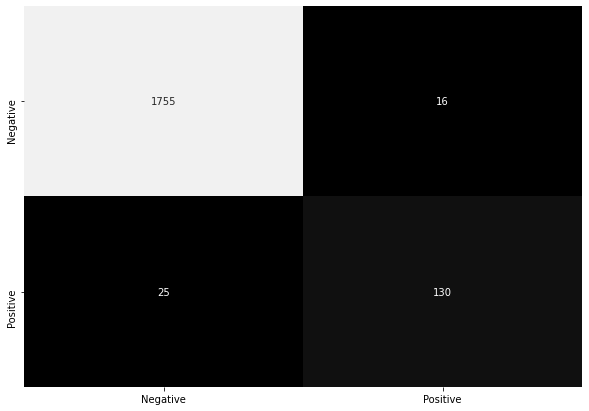

In [65]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =  [[1755,   16],
          [25,  130]] 
df_cm = pd.DataFrame(array, index = [i for i in ['Negative', 'Positive']],
                  columns = [i for i in ['Negative', 'Positive']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cbar=False, fmt="d", cmap='Greys_r', center=1000)